In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn import preprocessing
from scipy.stats.mstats import winsorize
from matplotlib.ticker import StrMethodFormatter
from regimeaware.routines import cfg
from datetime import datetime
from regimeaware.core.methodologies import RegimeWeightedLS
from tqdm import tqdm
import statsmodels.api as sm
import seaborn as sns
import cvxpy as cvx
from statsmodels.stats.weightstats import DescrStatsW
import warnings
warnings.filterwarnings('ignore')

dt = datetime(2023, 12, 31)

# cfg.data_fldr = r"C:\Users\franc\My Drive\bin\regimeaware\data"

n_stocks = 5000
n_states = 3
n_periods = 600

ff = pd.read_pickle(f'{cfg.data_fldr}/ff.pkl').loc[:dt, cfg.factor_set]
crsp = pd.read_pickle(f'{cfg.data_fldr}/crsp.pkl')
rt = pd.pivot_table(crsp[['excess_ret']], index='date', columns='permno', values='excess_ret')
mcap = crsp['shrout'].mul(crsp['prc'].abs()).xs(dt)

## 1. Number of states

\begin{aligned}
-\frac{n}{2}\log SSR
                  -\frac{n}{2}\left(1+\log\left(\frac{2\pi}{n}\right)\right)
                  -\frac{1}{2}\log\left(\left|W\right|\right)
\end{aligned}

\begin{aligned}
BIC = k \log \left( n \right) - 2 \log \left( \hat{L} \right)
\end{aligned}

BIC = -2*logLike + num_free_params * log(num_of_data)

## 2. Parameter recovery

In [7]:
mcap_sorted = mcap.sort_values(ascending=False)
mcap_coverage = mcap_sorted.cumsum().div(mcap.sum())
mcap_flags = mcap_coverage < .999
size_ids = mcap_flags[mcap_flags].index
active_ids = rt.reindex(size_ids, axis=1).iloc[-1].dropna().index
n_obs = rt[active_ids].count()
sample_ids = n_obs[n_obs > 300].index
print(f'Number of active stocks: {len(sample_ids)}')

Number of active stocks: 1036


### 2.1 HMM fitting on real factor returns

In [9]:
# Training sample
trn = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()  
# trn_raw = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()
# scaler = preprocessing.StandardScaler(copy=True).fit(trn_raw)
# trn = scaler.transform(trn_raw)
# trn = pd.DataFrame(trn, index=trn_raw.index, columns=trn_raw.columns)

hmm = GaussianHMM(
    n_components=n_states,
    covariance_type="diag",
    random_state=cfg.hm_rs,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)
hmm.fit(trn)

GaussianHMM(implementation='scaling', n_components=3, random_state=123, tol=0.1)

### 1.2 Fit RWLS

In [10]:
sec_rt = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()  # Stock excess returns
hmm_probs = pd.DataFrame(hmm.predict_proba(trn), index=trn.index)

collect_loadings = {}
collect_resid = {}

for sec_id in tqdm(sec_rt.columns):
    _y = sec_rt[sec_id].dropna()
    _y = _y - _y.mean()
    _x = trn.reindex(_y.index)
    _x = _x - _x.mean()
    _g = hmm_probs.reindex(_y.index)
    
    for s in range(n_states):
        mdl = sm.WLS(_y, _x, weights=_g[s], hasconst=False)
        collect_loadings[(sec_id, s)] = mdl.fit().params
        collect_resid[(sec_id, s)] = mdl.fit().resid.var(ddof=0)

B = pd.DataFrame.from_dict(collect_loadings, orient='index')
B.index.names = ["permno", "state"]
v = pd.Series(collect_resid)
v.index.names = ["permno", "state"]

100%|██████████| 1036/1036 [00:01<00:00, 525.71it/s]


In [11]:
_loadings = B.melt(ignore_index=False).reset_index().pivot_table(index="permno", columns=["variable", "state"], values="value")
_loadings = _loadings[[(x, y) for x in cfg.factor_set for y in range(n_states)]]

# sw = DescrStatsW(_loadings, weights=mcap.reindex(_loadings.index).fillna(0))
# _loadings_mean = pd.Series(sw.mean, index=_loadings.columns)
# _loadings_cov = pd.DataFrame(sw.cov, index=_loadings.columns, columns=_loadings.columns)

_loadings_cov = _loadings.cov()
_loadings_mean = _loadings.mean()

# Block-diagonal covariance matrix
_loadings_cov_diag = pd.DataFrame(index=_loadings_cov.index, columns=_loadings_cov.columns, dtype=float)
for fctr in cfg.factor_set:
    _loadings_cov_diag.loc[fctr, fctr] = _loadings_cov.loc[fctr, fctr].values

_loadings_cov = _loadings_cov_diag.fillna(0)

# True loadings simulation
np.random.seed(cfg.hm_rs)
_vals = np.random.multivariate_normal(mean=_loadings_mean, cov=_loadings_cov, size=n_stocks)

true_loadings = pd.DataFrame(_vals, columns=_loadings.columns).T
true_loadings.columns.name = "stock"
true_loadings.index.names = ["factor", "state"]
true_loadings = true_loadings.stack()

In [12]:
# Simulated stock returns
X, Z = hmm.sample(n_periods)
G = hmm.predict_proba(X)
R = np.zeros((n_periods, n_stocks))

np.random.seed(cfg.hm_rs)
E = np.random.normal(loc=0, scale=np.sqrt(.0025), size=R.shape)

for t, s_t in enumerate(Z):
    x_t = pd.Series(X[t], cfg.factor_set)
    x_t.index.name = "factor"
    R[t] += true_loadings.xs(s_t, level="state").mul(x_t).groupby("stock").sum()

R += E

In [13]:
collect_params = {}
for i in range(n_stocks):
    y = R[:, i]
    for s in range(n_states):
        mdl = sm.WLS(y, sm.add_constant(pd.DataFrame(X, columns=cfg.factor_set)), weights=G[:, s])
        # TODO: using the actual posterior probs for now until we nail down the issue
        collect_params[(s, i)] = mdl.fit().params

est_loadings = pd.DataFrame.from_dict(collect_params)
est_loadings.columns.names = ['state', 'stock']
est_loadings.index.name = 'factor'
est_loadings = est_loadings.melt(ignore_index=False).reset_index().set_index(['stock', 'state', 'factor']).squeeze()
est_loadings.name = 'estimated'

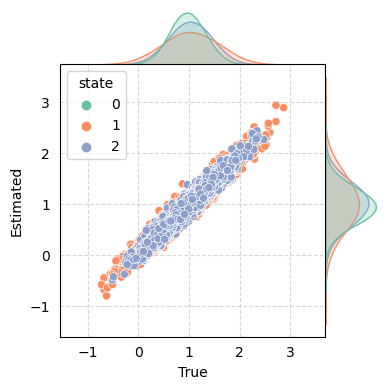

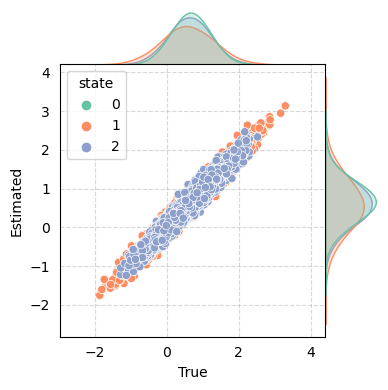

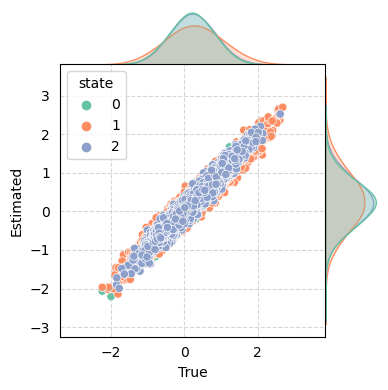

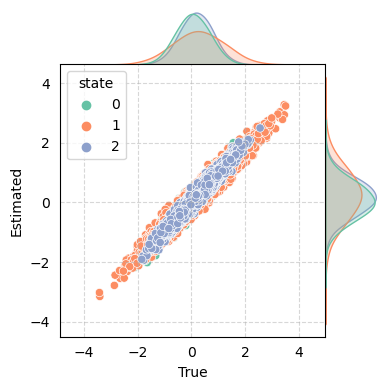

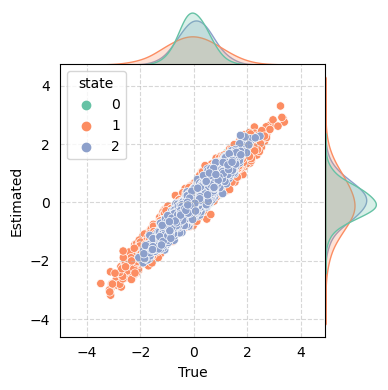

In [14]:
loadings = true_loadings.to_frame("True").join(est_loadings.to_frame("Estimated"))
loadings["delta"] = loadings["Estimated"] - loadings["True"]
loadings = loadings.join(true_loadings.groupby(["factor", "state"]).std().to_frame("sigma"))
loadings["std_delta"] = loadings["delta"] / loadings["sigma"]
loadings["abs_delta"] = loadings["delta"].abs()

for fctr in cfg.factor_set:
    data = loadings.xs(fctr).reset_index()
    g = sns.jointplot(data, x="True", y="Estimated", hue="state", palette="Set2", height=4, ratio=5, space=0, marginal_kws=dict(bw_adjust=2))
    g.ax_joint.grid(ls='--', alpha=.5, zorder=-25)
    g.ax_joint.tick_params(left=False, bottom=False)
    g.ax_marg_x.tick_params(left=False, bottom=False)
    g.ax_marg_y.tick_params(left=False, bottom=False)
    # g.ax_joint.set_xlabel(f"$\lambda_{fctr}$")
    # g.ax_joint.set_ylabel(f"$\hat{{\lambda}}_{{fctr}}$")
    # g.ax_joint.set_ylim(g.ax_joint.get_xlim())
    # g.ax_joint.set_yticks(g.ax_joint.get_xticks())
    # ax.set_yticklabels(ax.get_xticklabels())
    # fig = plt.gcf()
    # fig.suptitle(fctr)
    # plt.tight_layout()
    plt.show()

## 3. Portfolio simulation

In [15]:
import sys
sys.exit()

SystemExit: 

In [ ]:
def K(w):
    u = cvx.vstack([cvx.log(pi[i])
      - gamma * mus[i] @ w
      + (gamma**2/2) * cvx.quad_form(w, Sigmas[i]) for i in range(k)])
    return cvx.log_sum_exp(u)

In [ ]:
w = cvx.Variable(n)
objective = cvx.Minimize(K(w))
constraints = [ w >= 0, cvx.sum(w) == 1 ]
egm_prob = cvx.Problem(objective, constraints)
egm_prob.solve(solver=cvx.MOSEK)


# -----------------------------------------------

BIC = -2*logLike + num_free_params * log(num_of_data)

In [ ]:
n = 2

Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()

mdl = GaussianHMM(
    n_components=n,
    covariance_type="diag",
    random_state=cfg.hm_rs,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)
mdl.fit(X)

\begin{aligned}
-\frac{n}{2}\log SSR
                  -\frac{n}{2}\left(1+\log\left(\frac{2\pi}{n}\right)\right)
                  -\frac{1}{2}\log\left(\left|W\right|\right)
\end{aligned}

In [ ]:
n = 2

Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()

mdl = GaussianHMM(
    n_components=n,
    covariance_type="diag",
    random_state=cfg.hm_rs,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)
mdl.fit(X)


g = pd.DataFrame(mdl.predict_proba(X), index=ff.index, columns=range(n))

collect_betas = {}
collect_resid = {}

for sec_id in tqdm(Y.columns):
    y = Y[sec_id].dropna()
    rwls = RegimeWeightedLS(endog=y, exog=X, emission_prob=g)
    rwls.fit(add_constant=True)

    collect_betas[sec_id] = rwls.params.stack()
    collect_resid[sec_id] = rwls.resid.var(ddof=0)


\begin{aligned}
BIC = k \log \left( n \right) - 2 \log \left( \hat{L} \right)
\end{aligned}

In [ ]:
"""
I'm adding up the BIC for now, but there is an issue with the number of observations. The loglikelihood
of stocks with longer time series will be higher, so the BIC will be lower. I need to adjust for that.
I also need to adjust for the number of regimes (and total number of parameters) in the model.
"""
collect_mdl_llf = {}
collect_mdl_bic = {}

for n_states in range(1, 3):
    Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
    X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()

    hmm = GaussianHMM(
        n_components=n_states,
        covariance_type="diag",
        random_state=cfg.hm_rs,
        min_covar=cfg.hm_min_covar,
        tol=cfg.hm_tol,
        implementation=cfg.hm_implementation
    )
    hmm.fit(X)


    g = pd.DataFrame(hmm.predict_proba(X), index=ff.index, columns=range(n_states))

    collect_llf = {}
    collect_bic = {}

    for sec_id in tqdm(Y.columns, desc=f"{n_states} states"):
        y = Y[sec_id].dropna()

        _llf = 0
        _bic = 0
        for s in range(n_states):
            w = g[s].reindex(y.index)
            mdl = sm.WLS(y, sm.add_constant(X.reindex(y.index)), weights=w)
            _llf += mdl.fit().llf
            _bic += mdl.fit().bic

        collect_llf[sec_id] = _llf
        collect_bic[sec_id] = _bic

    collect_mdl_llf[n_states] = pd.Series(collect_llf)
    collect_mdl_bic[n_states] = pd.Series(collect_bic)

In [ ]:
hmm._get_n_fit_scalars_per_param()

In [ ]:
k = sum(hmm._get_n_fit_scalars_per_param().values())

In [ ]:
# nobs2 = self.nobs / 2.0
# SSR = np.sum((self.wendog - np.dot(self.wexog, params))**2, axis=0)
# llf = -np.log(SSR) * nobs2      # concentrated likelihood
# llf -= (1+np.log(np.pi/nobs2))*nobs2  # with constant
# llf += 0.5 * np.sum(np.log(self.weights))

In [ ]:
s = 0
ssr = np.sum(rwls.resid[s] ** 2)
n = len(y)
w = g[s].reindex(y.index)

-n / 2 * np.log(ssr) - n / 2 * (1 + np.log(2 * np.pi / n)) + 1 /2 * np.sum(np.log(w))

In [ ]:
mdl = sm.WLS(y, sm.add_constant(X.reindex(y.index)), weights=w)
mdl.fit().llf

In [ ]:
mdl.fit().summary()

In [ ]:
mdl.fit(cov_type="HAC", cov_kwds={'maxlags': 12}).summary()

In [ ]:
mdl.fit().params

In [ ]:
n = 3

Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()

mdl = GaussianHMM(
    n_components=n,
    covariance_type="diag",
    random_state=cfg.hm_rs,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)
mdl.fit(X)


g = pd.DataFrame(mdl.predict_proba(X), index=ff.index, columns=range(n))

collect_betas = {}
collect_resid = {}

for sec_id in tqdm(Y.columns):
    y = Y[sec_id].dropna()
    mdl = RegimeWeightedLS(endog=y, exog=X, emission_prob=g)
    mdl.fit(add_constant=True)

    collect_betas[sec_id] = mdl.params.stack()
    collect_resid[sec_id] = mdl.resid.var(ddof=0)

In [ ]:
pd.DataFrame.from_dict(collect_resid).T.stack().mean()

In [ ]:
pd.DataFrame.from_dict(collect_resid).T.stack().plot.hist(bins=50, alpha=.5, density=True)

In [ ]:
import scipy.stats as stats

stats.chi2.fit(pd.DataFrame.from_dict(collect_resid).T[0])

In [ ]:
pd.Series(np.random.chisquare(1, 30000)).plot.hist(bins=50, alpha=.5, density=True)

In [ ]:
B = pd.DataFrame.from_dict(collect_betas).T

In [ ]:
(B["mktrf"].max(axis=1) - B["mktrf"].min(axis=1)).plot.hist(bins=100)

In [ ]:
aa = (B["mktrf"].max(axis=1) - B["mktrf"].min(axis=1))
n_obs = rt.count()[aa.index]
size = crsp["mktcap"].xs('2023-12-31').reindex(aa.index).fillna(0)
size = size.rank(pct=True)
df = aa.to_frame("delta").join(n_obs.to_frame("n_obs")).join(size.to_frame("size"))
df.sort_values("delta", ascending=False)

In [ ]:
df.plot.scatter(x="n_obs", y="delta", c="size", cmap="coolwarm_r", alpha=.5)

- the biggest factor loading deltas usually take place in short time series
- the same can be said with small stocks
- weighting by mcap should alleviate some of this

In [ ]:
(B["mktrf"].max(axis=1) - B["mktrf"].min(axis=1)).sort_values(ascending=False).head(20)

In [ ]:
B["mktrf"].xs(78170)

In [ ]:
rt[78170].dropna().plot()

In [ ]:
np.random.multivariate_normal(mean=B["mktrf"].mean(), cov=B["mktrf"].cov(), size=2)

In [ ]:
from statsmodels.stats.weightstats import DescrStatsW
labels = B.drop("const", axis=1).columns
sw = DescrStatsW(B[labels], weights=crsp["mktcap"].xs('2023-12-31').reindex(B.index).fillna(0))
display(pd.DataFrame(sw.cov, index=labels, columns=labels))
display(pd.Series(sw.mean, index=labels))

In [ ]:
pd.DataFrame(np.linalg.inv(np.diag(sw.std)) @ sw.cov @ np.linalg.inv(np.diag(sw.std)), index=labels, columns=labels)

In [ ]:
from statsmodels.stats.weightstats import DescrStatsW

loadings_dist = {}

for fctr in ["mktrf", "smb", "hml", "rmw", "cma"]:
    _dist = {}
    sw = DescrStatsW(B[fctr], weights=crsp["mktcap"].xs('2023-12-31').reindex(B[fctr].index).fillna(0))
    _dist["mu"] = sw.mean
    _dist["cov"] = sw.cov
    loadings_dist[fctr] = _dist

loadings_dist

In [ ]:
np.linalg.inv(np.diag(sw.std)) @ sw.cov @ np.linalg.inv(np.diag(sw.std))

In [ ]:
B["mktrf"].corr()

In [ ]:
B["mktrf"].mean()

In [ ]:
sw.mean

In [ ]:
np.random.multivariate_normal(mean=sw.mean, cov=sw.cov, size=10)

In [ ]:
B["mktrf"].cov()

In [ ]:
mdl.covars_

## Recovery

In [ ]:
states_to_try = range(1, 9)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)

# trn_raw = ff.copy()
# scaler = preprocessing.StandardScaler(copy=True).fit(trn_raw)
# trn = scaler.transform(trn_raw)
trn = ff.copy()

collect_mdls = {}

for n in states_to_try:
    mdl = GaussianHMM(
        n_components=n,
        covariance_type="diag",
        random_state=999,
        min_covar=cfg.hm_min_covar,
        tol=cfg.hm_tol,
        implementation=cfg.hm_implementation
    )
    mdl.fit(trn)
    _score = mdl.bic(trn)
    collect_mdls[_score] = mdl
    bic[n] = _score
    aic[n] = mdl.aic(trn)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3.25))
plot_map = {'AIC': (aic, '--', 1.25, 'o'), 'BIC': (bic, '-', 1.75, 's')}

for label, params in plot_map.items():
    ax.plot(params[0], color='k', marker=params[3], mfc='white', lw=params[2], ls=params[1])
    ax.grid(ls='--', alpha=.75)

# ax.set_title('Information Criterion', weight='bold')
ax.set_ylabel('Information Criterion')
ax.set_xlabel('Number of Market Regimes')
ax.legend(['AIC', 'BIC'])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='both', bottom=False, left=False)
plt.tight_layout()
plt.show()


In [ ]:
mdl = collect_mdls[min(collect_mdls)]
n_states = mdl.n_components
print(f'Number of states: {n_states}')

hm_mu = mdl.means_
hm_sigma = mdl.covars_
hm_transmat = mdl.transmat_
hm_start_p = mdl.startprob_
hm_post_p = mdl.predict_proba(X=trn)

In [ ]:
res_var = pd.Series(index=pd.MultiIndex.from_tuples([(dt, x) for x in sample_ids], names=['date', 'id']))

Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()
g = pd.DataFrame(hm_post_p, index=ff.index, columns=range(n_states))
B = pd.DataFrame(index=ff.index, columns=ff.columns)

collect_betas = {}
collect_resid = {}

for sec_id in tqdm(Y.columns):
    y = Y[sec_id].dropna()
    mdl = RegimeWeightedLS(endog=y, exog=X, emission_prob=g)
    mdl.fit(add_constant=True)

    collect_betas[sec_id] = mdl.params.stack()
    collect_resid[sec_id] = mdl.resid.var(ddof=0)


state_betas = pd.DataFrame.from_dict(collect_betas)
state_betas.index.names = ['param', 'state']
state_var = pd.DataFrame(collect_resid)
state_var.index.name = "state"

In [ ]:
Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()
X = sm.add_constant(X)

collect_betas = {}
collect_var = {}

for sec_id in tqdm(Y.columns):
    y = Y[sec_id]
    cmn_idx = X.join(y).dropna().index
    mdl = sm.OLS(y.reindex(cmn_idx), X.reindex(cmn_idx))
    mdl_fit = mdl.fit()

    collect_betas[sec_id] = mdl_fit.params.copy()
    collect_var[sec_id] = mdl_fit.mse_resid

ols_var = pd.Series(collect_var)
ols_betas = pd.DataFrame(collect_betas)

In [ ]:
# Empirical distribution of factor loadings
fig, axs = plt.subplots(nrows=len(cfg.factor_set), ncols=1, figsize=(3.75, len(cfg.factor_set) * 1.5), sharex=True, sharey=True)
for i, fact in enumerate(cfg.factor_set):
    _vals = ols_betas.xs(fact).to_frame().join(mcap.to_frame('mcap'))
    _vals[fact] = winsorize(_vals[fact], limits=[.01, .01]).data
    
    _mu = _vals[fact].mean()
    _sigma = _vals[fact].std()
    
    ax = axs.flatten()[i]
    ax.text(.95, .95, f'Mean: {_mu:.2f}\nStd: {_sigma:.2f}', ha='right', va='top', transform=ax.transAxes)
    sns.kdeplot(data=_vals, x=fact, ax=ax, bw_adjust=2, fill=True, zorder=25, weights='mcap')
    ax.set_title(fact, weight='bold')
    ax.grid(ls='--', alpha=.5, zorder=-25)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim(-3.5, 3.5)
    ax.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()

In [ ]:
# Empirical distribution of factor loadings
fig, axs = plt.subplots(nrows=len(cfg.factor_set), ncols=1, figsize=(5, len(cfg.factor_set) * 2), sharex='row', sharey='row')
collect_params = {}
for i, fact in enumerate(cfg.factor_set):
    ax = axs[i]
    for m in range(n_states):
        _vals = state_betas.xs(fact).xs(m).to_frame(fact).join(mcap.to_frame('mcap'))
        _vals[fact] = winsorize(_vals[fact], limits=[.01, .01]).data
        sns.kdeplot(data=_vals, x=fact, ax=ax, bw_adjust=1.5, fill=False, zorder=25, weights='mcap')
        collect_params[(fact, m)] = (_vals[fact].mean(), _vals[fact].std())

    ax.legend([f"State {x}" for x in range(n_states)], loc='upper right')
    ax.set_title(f"{fact} ({m})", weight='bold')
    ax.axvline(np.mean(_vals), c='firebrick')
    ax.grid(ls='--', alpha=.5, zorder=-25)
    ax.set_xlim(-4, 4)
    ax.tick_params(axis='both', which='both', length=0)

plt.tight_layout()

In [ ]:
hm_mu = mdl.means_
hm_sigma = mdl.covars_
hm_transmat = mdl.transmat_
hm_start_p = mdl.startprob_
hm_post_p = mdl.predict_proba(X=trn)

In [ ]:
hm_mu

In [ ]:
mdl = GaussianHMM(
    n_components=n_states,
    covariance_type="diag",
    random_state=999,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)
mdl.means_ = hm_mu
mdl.transmat_ = hm_transmat
mdl.startprob_ = hm_start_p
mdl.means_ = hm_mu
mdl.fit(ff)

# TODO:
The point of using the historical data should be 

1. Have an idea of how many regimes are there taking the 5-factor model (3 states?)
1. Given these m-states, what are the distributions of these factors, are they statistically different?
1. What are the state-dependent parameters of these distributions? (to be used in the simulations)
1. Given these m-states simulate long paths for the hidden states
1. Simulate synthetic returns for n stocks, drawing the betas from the corresponding distributions 

In [ ]:
startprob = np.array([0.6, 0.3, 0.1, 0.0])
transmat = np.array(
    [
        [0.7, 0.2, 0.0, 0.1],
        [0.3, 0.5, 0.2, 0.0],
        [0.0, 0.3, 0.5, 0.2],
        [0.2, 0.0, 0.2, 0.6]
    ]
)

means = np.array(
    [
        [0.0, 0.0],
        [0.0, 11.0],
        [9.0, 10.0],
        [11.0, -1.0]
    ]
)

covars = .5 * np.tile(np.identity(2), (4, 1, 1))

# Build an HMM instance and set parameters
gen_model = hmm.GaussianHMM(n_components=4, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
gen_model.startprob_ = startprob
gen_model.transmat_ = transmat
gen_model.means_ = means
gen_model.covars_ = covars

# Generate samples
X, Z = gen_model.sample(500)

Z

In [ ]:
pd.DataFrame(gen_model.predict_proba(X)).round(4)  # The probability of each state at each time point is pretty much either 0 or 1

In [ ]:
np.tile(np.identity(2), (2, 1, 1))

In [ ]:
startprob = np.array([1, 0])
transmat = np.array(
    [
        [0.85, 0.15],
        [0.4, 0.6],
    ]
)

means = np.array(
    [
        [0.1],
        [-0.1],
    ]
)

covars = np.array([1, 1]).reshape(-1, 1)

# Build an HMM instance and set parameters
gen_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", random_state=12345)

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
gen_model.startprob_ = startprob
gen_model.transmat_ = transmat
gen_model.means_ = means
gen_model.covars_ = covars

# Generate samples
X, Z = gen_model.sample(120)

Z

In [ ]:
transmat = np.array(
    [
        [0.85, 0.15],
        [0.4, 0.6],
    ]
)
np.linalg.matrix_power(transmat, 9999999).T @ np.array([1, 0]).reshape(-1, 1)